In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d nisharani1711/real-vs-ai-images


Dataset URL: https://www.kaggle.com/datasets/nisharani1711/real-vs-ai-images
License(s): CC-BY-NC-SA-4.0
 98% 995M/0.99G [00:05<00:00, 159MB/s]
100% 0.99G/0.99G [00:05<00:00, 193MB/s]


In [ ]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile("real-vs-ai-images.zip", 'r') as zip_ref:
    zip_ref.extractall("real-vs-ai-images")

In [ ]:
import os

def print_tree(startpath, max_depth=3, prefix=""):
    startpath = os.path.abspath(startpath)
    for root, dirs, files in os.walk(startpath):
        # Calculate depth
        depth = root.replace(startpath, "").count(os.sep)
        if depth >= max_depth:
            continue
        indent = " " * 4 * depth
        print(f"{indent}📂 {os.path.basename(root)}/")
        for f in files[:5]:  # only preview first 5 files
            print(f"{indent}    {f}")
        if len(files) > 5:
            print(f"{indent}    ... ({len(files)} files)")

print("Current working directory:", os.getcwd())
print("\nDataset structure:\n")
print_tree("dataset", max_depth=3)


Current working directory: /content

Dataset structure:

📂 dataset/
    📂 REAL VS AI/
        📂 REAL/
            02826.jpg
            04112.jpg
            04443.jpg
            04177.jpg
            00174.jpg
            ... (3710 files)
        📂 AI/


In [ ]:
import os, shutil

base_dir = "dataset/REAL VS AI"
real_dir = os.path.join(base_dir, "REAL")
ai_nested_dir = os.path.join(base_dir, "AI", "AI")  # the nested one
ai_dir = os.path.join(base_dir, "AI_fixed")

os.makedirs(ai_dir, exist_ok=True)

# Move files from nested AI folder to AI_fixed
for f in os.listdir(ai_nested_dir):
    src = os.path.join(ai_nested_dir, f)
    dst = os.path.join(ai_dir, f)
    shutil.copy(src, dst)

print("✅ Fixed structure:")
print("REAL images:", len(os.listdir(real_dir)))
print("AI images:", len(os.listdir(ai_dir)))


✅ Fixed structure:
REAL images: 3710
AI images: 3822


In [ ]:
import os, shutil, random

base_dir = "dataset/REAL VS AI"
real_dir = os.path.join(base_dir, "REAL")
ai_dir   = os.path.join(base_dir, "AI_fixed")

final_dataset = "dataset/final_data"
real_final = os.path.join(final_dataset, "REAL")
ai_final   = os.path.join(final_dataset, "AI")

os.makedirs(real_final, exist_ok=True)
os.makedirs(ai_final, exist_ok=True)

# Sample 3200 from each
real_files = random.sample(os.listdir(real_dir), 3700)
ai_files   = random.sample(os.listdir(ai_dir), 3700)

# Copy files
for f in real_files:
    shutil.copy(os.path.join(real_dir, f), os.path.join(real_final, f))

for f in ai_files:
    shutil.copy(os.path.join(ai_dir, f), os.path.join(ai_final, f))

print("✅ Final dataset created:")
print("REAL:", len(os.listdir(real_final)))
print("AI:", len(os.listdir(ai_final)))


✅ Final dataset created:
REAL: 3700
AI: 3700


In [ ]:
import tensorflow as tf

# Path to your final dataset
dataset_path = "dataset/final_data"

# Parameters
img_size = (224, 224)   # Resize all images to 224x224
batch_size = 32
val_split = 0.2         # 20% for validation

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",          # 0 = REAL, 1 = AI
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=val_split,
    subset="training"
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=val_split,
    subset="validation"
)

# Get class names before prefetching
class_names = train_ds.class_names

# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


print("✅ Dataset loaded successfully")
print("Training batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())

Found 7400 files belonging to 2 classes.
Using 5920 files for training.
Found 7400 files belonging to 2 classes.
Using 1480 files for validation.
✅ Dataset loaded successfully
Training batches: 185
Validation batches: 47


Class names: ['AI', 'REAL']


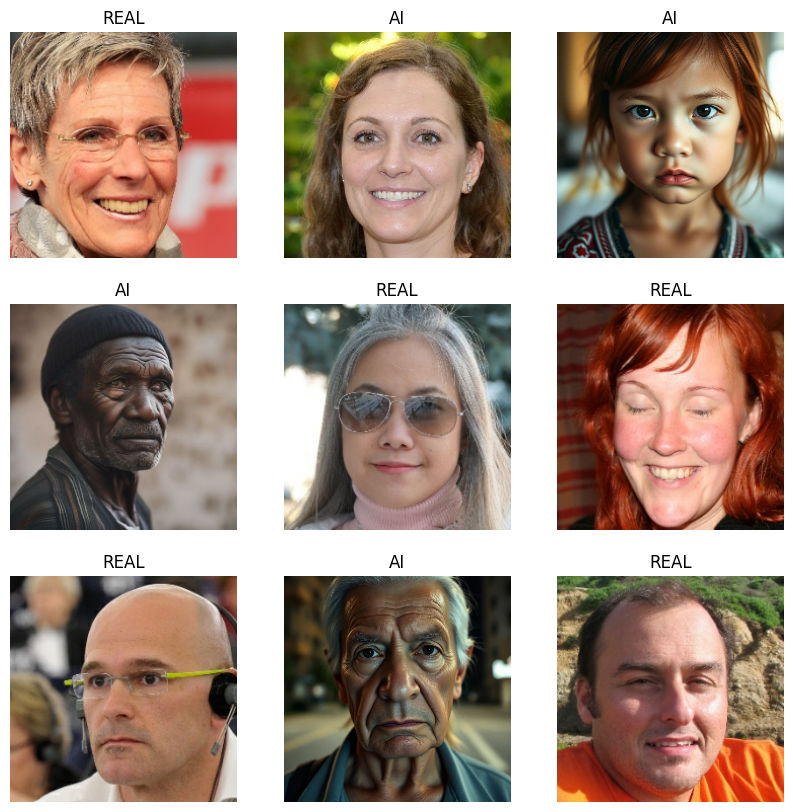

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names
# class_names is already defined in the previous cell

print("Class names:", class_names)

# Take one batch from train_ds
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

# Assuming train_ds and val_ds are already defined and preprocessed

# 1️⃣ MobileNetV2 as feature extractor
base_model_cnn_only = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model_cnn_only.trainable = False  # Freeze pre-trained weights

# 2️⃣ Add Dense layers for binary classification
model_cnn_only = models.Sequential([
    base_model_cnn_only,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification: REAL vs AI
])

# 3️⃣ Compile and train the model
model_cnn_only.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history_cnn = model_cnn_only.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)  # You can adjust epochs

# Save model (optional)
# model_cnn_only.save('cnn_only_model.h5')

Epoch 1/10
  8/284 ━━━━━━━━━━━━━━━━━━━━ 7:54 2s/step - accuracy: 0.3699 - loss: 0.5570

KeyboardInterrupt: 

71/71 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.3301 - loss: -47.4281
Validation Loss: -39.7434
Validation Accuracy: 0.3396


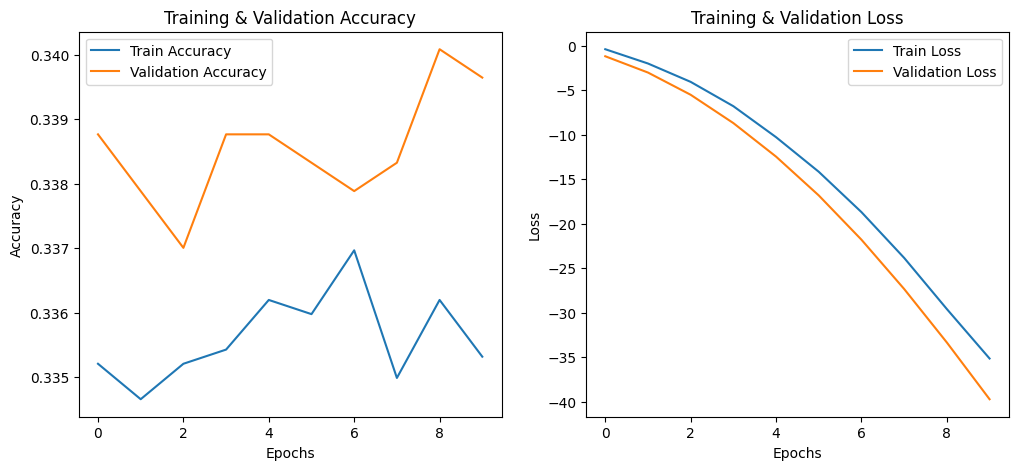

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


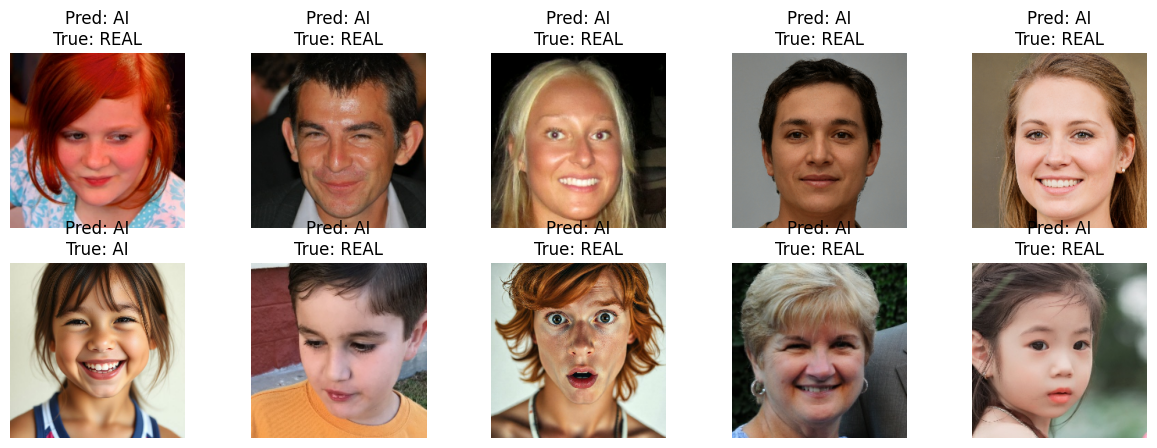

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# -----------------------------
# 1️⃣ Evaluate the model
# -----------------------------
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# -----------------------------
# 2️⃣ Plot training history
# -----------------------------
# Ensure you have 'history' from model.fit()
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# -----------------------------
# 3️⃣ Show sample predictions
# -----------------------------
for images, labels in val_ds.take(1):  # Take one batch
    preds = model.predict(images)
    preds = np.round(preds)  # Convert sigmoid output to 0 or 1

    plt.figure(figsize=(15,5))
    for i in range(min(10, images.shape[0])):  # Show first 10 images
        plt.subplot(2,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = 'AI' if labels[i].numpy() == 1 else 'REAL'
        pred_label = 'AI' if preds[i] == 1 else 'REAL'
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis('off')
    plt.show()


In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Path to your final dataset
# -----------------------------
dataset_path = "dataset/final_data"
categories = ["REAL", "AI"]

# -----------------------------
# Function to extract features
# -----------------------------
def extract_forensic_features(img_path):
    img = cv2.imread(img_path)
    # Check if image is loaded correctly
    if img is None:
        print(f"Warning: Could not load image {img_path}. Skipping.")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 1️⃣ Mean pixel value
    mean_val = np.mean(img_gray)

    # 2️⃣ Standard deviation (contrast)
    std_val = np.std(img_gray)

    # 3️⃣ Sharpness (Laplacian variance)
    lap_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()

    # 4️⃣ Edge density (Canny edges)
    edges = cv2.Canny(img_gray, 100, 200)
    edge_density = np.sum(edges) / edges.size

    # 5️⃣ Color histogram (R, G, B) - Using mean of histogram values as a simple feature
    # Ensure image is not empty before calculating histogram
    if img.size == 0:
         hist_r, hist_g, hist_b = 0, 0, 0
    else:
        hist_r = np.mean(cv2.calcHist([img], [0], None, [256], [0,256]))
        hist_g = np.mean(cv2.calcHist([img], [1], None, [256], [0,256]))
        hist_b = np.mean(cv2.calcHist([img], [2], None, [256], [0,256]))


    return [mean_val, std_val, lap_var, edge_density, hist_r, hist_g, hist_b]

# -----------------------------
# Extract features for dataset
# -----------------------------
data = []
labels = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    label = 0 if category == "REAL" else 1  # 0 = REAL, 1 = AI

    for img_file in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_file)
        feats = extract_forensic_features(img_path)
        if feats is not None: # Only append if feature extraction was successful
            data.append(feats)
            labels.append(label)
        else:
            print(f"Skipping {img_path}")


# -----------------------------
# Save features to CSV
# -----------------------------
df = pd.DataFrame(data, columns=[
    'mean', 'std', 'laplacian_var', 'edge_density', 'hist_r', 'hist_g', 'hist_b'
])
df['label'] = labels
df.to_csv("forensic_features.csv", index=False)

print("✅ Forensic features extracted and saved to forensic_features.csv")

100%|██████████| 3700/3700 [02:10<00:00, 28.35it/s]


✅ Forensic features extracted and saved to forensic_features.csv


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Import StandardScaler
import os
import cv2 # Import cv2 for forensic feature extraction

# -----------------------------
# Path to your final dataset
# -----------------------------
dataset_path = "dataset/final_data"
categories = ["REAL", "AI"]
img_size = (224, 224)

# -----------------------------
# MobileNetV2 as feature extractor
# -----------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet', pooling='avg'
)
base_model.trainable = False  # Freeze weights

# -----------------------------
# Function to extract forensic features (same as before, adapted for direct image array)
# -----------------------------
def extract_forensic_features_from_array(img_np):
    # img_np is expected to be a numpy array in RGB format (H, W, C), likely float32.
    # Convert to uint8 for OpenCV compatibility
    img_np_uint8 = img_np.astype(np.uint8)

    img_gray = cv2.cvtColor(img_np_uint8, cv2.COLOR_RGB2GRAY)

    mean_val = np.mean(img_gray)
    std_val = np.std(img_gray)
    # Ensure data type is suitable for Laplacian
    lap_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()

    edges = cv2.Canny(img_gray, 100, 200)
    edge_density = np.sum(edges) / edges.size

    if img_np_uint8.size == 0:
         hist_r, hist_g, hist_b = 0, 0, 0
    else:
        # cv2.calcHist expects a list of images, channels, mask, histSize, ranges
        hist_r = np.mean(cv2.calcHist([img_np_uint8], [0], None, [256], [0,256]))
        hist_g = np.mean(cv2.calcHist([img_np_uint8], [1], None, [256], [0,256]))
        hist_b = np.mean(cv2.calcHist([img_np_uint8], [2], None, [256], [0,256]))

    return [mean_val, std_val, lap_var, edge_density, hist_r, hist_g, hist_b]


# -----------------------------
# Extract both CNN and Forensic features by iterating through files
# -----------------------------
X_cnn = []
X_forensic = []
y_combined = []
image_paths = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    label = 0 if category == "REAL" else 1  # 0 = REAL, 1 = AI
    for img_file in sorted(os.listdir(folder_path)): # Sort files for consistent order
        img_path = os.path.join(folder_path, img_file)

        # Load and preprocess image for CNN
        img = tf.keras.utils.load_img(img_path, target_size=img_size)
        img_array = tf.keras.utils.img_to_array(img)
        img_array_processed = tf.keras.applications.mobilenet_v2.preprocess_input(np.expand_dims(img_array, axis=0))

        # Extract CNN features
        cnn_features = base_model(img_array_processed, training=False).numpy()
        X_cnn.append(cnn_features[0])

        # Extract forensic features
        forensic_feats = extract_forensic_features_from_array(img_array)
        if forensic_feats is not None:
            X_forensic.append(forensic_feats)
            y_combined.append(label)
            image_paths.append(img_path) # Keep track of paths for debugging/verification
        else:
            print(f"Skipping forensic feature extraction for {img_path}")
            # If forensic features failed, remove the corresponding CNN feature to keep lists aligned
            X_cnn.pop()


X_cnn = np.array(X_cnn)
X_forensic = np.array(X_forensic)
y_combined = np.array(y_combined)

# Scale forensic features
scaler = StandardScaler()
X_forensic_scaled = scaler.fit_transform(X_forensic)


# Combine features
if X_cnn.shape[0] == X_forensic_scaled.shape[0]: # Use scaled forensic features
    X_combined = np.hstack([X_cnn, X_forensic_scaled])
    print(f"✅ Features combined successfully. Shape: {X_combined.shape}")
else:
    print(f"Error: Mismatch in number of CNN features ({X_cnn.shape[0]}) and scaled forensic features ({X_forensic_scaled.shape[0]}).")


# -----------------------------
# Split combined features into training and validation sets
# -----------------------------
if X_combined.shape[0] > 0:
    X_train, X_val, y_train, y_val = train_test_split(
        X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
    )

    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # -----------------------------
    # Build a hybrid classifier
    # -----------------------------
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # -----------------------------
    # Train the model
    # -----------------------------
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=10,
                        batch_size=32)
else:
    print("Cannot split and train the model due to feature extraction or combination issues.")

✅ Features combined successfully. Shape: (7400, 1287)
Training data shape: (5920, 1287)
Validation data shape: (1480, 1287)
Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6651 - loss: 0.6053 - val_accuracy: 0.8480 - val_loss: 0.3417
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8400 - loss: 0.3631 - val_accuracy: 0.8764 - val_loss: 0.2739
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8784 - loss: 0.2867 - val_accuracy: 0.8939 - val_loss: 0.2551
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8964 - loss: 0.2502 - val_accuracy: 0.9014 - val_loss: 0.2316
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9035 - loss: 0.2334 - val_accuracy: 0.9122 - val_loss: 0.2198
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9156 - loss: 0.2081 - val_accuracy: 0.9162 - val_loss: 0.2107
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9283 - loss: 0.1795 - val_accuracy: 

Validation Loss: 0.1909
Validation Accuracy: 0.9250


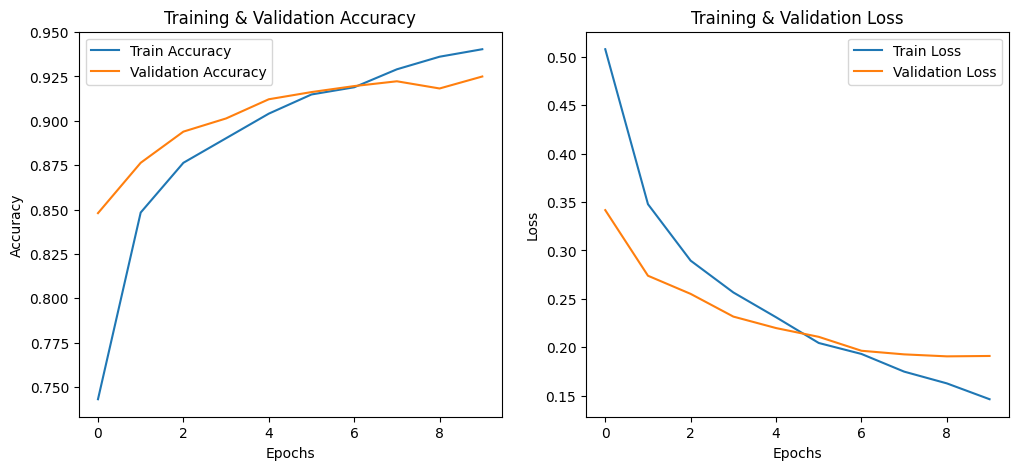


Sample predictions are not shown here as the model was trained on combined features.
To visualize predictions on images, you would need to predict on image data and then display the images.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Evaluate the model
# -----------------------------
loss, acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

# -----------------------------
# 2️⃣ Plot training history
# -----------------------------
# Ensure you have 'history' from model.fit()
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# -----------------------------
# 3️⃣ Show sample predictions (This part is a bit tricky with combined features)
# We'll just show the evaluation metrics for now.
# To show sample predictions with images, we would need to load the images again
# and predict for a small batch, then display the images with true/predicted labels.
# -----------------------------
print("\nSample predictions are not shown here as the model was trained on combined features.")
print("To visualize predictions on images, you would need to predict on image data and then display the images.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

--- Predictions ---


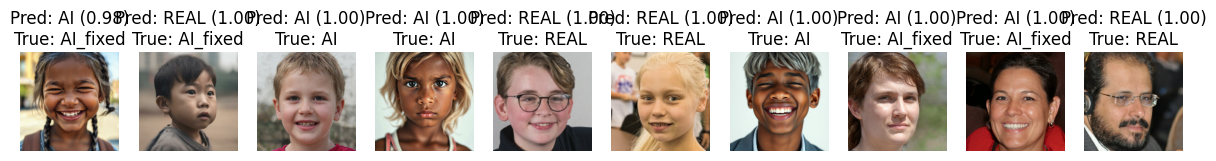

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import os
import random

# Assuming the hybrid model 'model' and the base_model for CNN embeddings are already loaded in the environment
# If not, you would need to load them first:
# model = tf.keras.models.load_model('path/to/your/hybrid_model.h5') # If you saved the hybrid model
# base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet', pooling='avg') # If not already loaded
# base_model.trainable = False

# -----------------------------
# Get test images from the validation dataset
# -----------------------------
# We'll get a batch from the validation dataset and use those images for testing
# Note: This is for demonstration. For a proper evaluation, you'd use a separate test set.
test_images, test_labels = next(iter(val_ds)) # Get one batch

# Optionally, you can select a smaller number of images from the batch
num_test_images = 10 # Increased the number of test images
test_images = test_images[:num_test_images]
test_labels = test_labels[:num_test_images]


# -----------------------------
# Function to extract forensic features (same as before)
# This function needs to handle TF tensors, or we convert images back to numpy
# Let's convert images back to numpy and use the existing function
# -----------------------------
def extract_forensic_features(img_np):
    # img_np is expected to be a numpy array in RGB format (H, W, C)
    # Convert RGB to BGR for OpenCV if needed by your cv2 version, but the previous function expected RGB
    # Let's stick to RGB processing in the function for consistency.
    img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    mean_val = np.mean(img_gray)
    std_val = np.std(img_gray)
    lap_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()

    edges = cv2.Canny(img_gray, 100, 200)
    edge_density = np.sum(edges) / edges.size

    if img_np.size == 0:
         hist_r, hist_g, hist_b = 0, 0, 0
    else:
        # cv2.calcHist expects a list of images, channels, mask, histSize, ranges
        hist_r = np.mean(cv2.calcHist([img_np.astype(np.uint8)], [0], None, [256], [0,256]))
        hist_g = np.mean(cv2.calcHist([img_np.astype(np.uint8)], [1], None, [256], [0,256]))
        hist_b = np.mean(cv2.calcHist([img_np.astype(np.uint8)], [2], None, [256], [0,256]))


    return [mean_val, std_val, lap_var, edge_density, hist_r, hist_g, hist_b]


# -----------------------------
# Prepare features for prediction
# -----------------------------
test_cnn_features = []
test_forensic_features = []
processed_test_images = [] # To store images that were successfully processed

for img_tensor in test_images:
    img_np = img_tensor.numpy().astype(np.uint8) # Convert TF tensor to numpy array

    # Extract CNN features
    img_array = np.expand_dims(img_np, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array.astype(np.float32)) # Preprocess
    cnn_features = base_model(img_array, training=False).numpy()
    test_cnn_features.append(cnn_features[0]) # Remove batch dimension

    # Extract forensic features
    forensic_feats = extract_forensic_features(img_np)
    if forensic_feats is not None:
        test_forensic_features.append(forensic_feats)
        processed_test_images.append(img_np) # Add to processed list if successful
    else:
         # If forensic feature extraction failed, remove the corresponding CNN feature
        test_cnn_features.pop()


# Convert to numpy arrays
test_cnn_features = np.array(test_cnn_features)
test_forensic_features = np.array(test_forensic_features)
processed_test_images = np.array(processed_test_images)


# Combine features
if test_cnn_features.shape[0] > 0 and test_forensic_features.shape[0] > 0 and test_cnn_features.shape[0] == test_forensic_features.shape[0]:
    test_combined_features = np.hstack([test_cnn_features, test_forensic_features])

    # -----------------------------
    # Make predictions
    # -----------------------------
    predictions = model.predict(test_combined_features)

    # -----------------------------
    # Display results
    # -----------------------------
    print("\n--- Predictions ---")
    plt.figure(figsize=(15, 5))
    for i in range(test_combined_features.shape[0]):
        prediction = predictions[i][0]
        predicted_label = "AI" if prediction > 0.5 else "REAL"
        confidence = prediction if predicted_label == "AI" else (1 - prediction)
        # Use class_names directly as it should be ['AI', 'REAL']
        true_label = class_names[test_labels[i].numpy()]

        plt.subplot(1, test_combined_features.shape[0], i + 1)
        plt.imshow(processed_test_images[i])
        plt.title(f"Pred: {predicted_label} ({confidence:.2f})\nTrue: {true_label}")
        plt.axis('off')
    plt.show()


else:
    print("Could not process images for prediction. Please check the data loading and feature extraction steps.")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


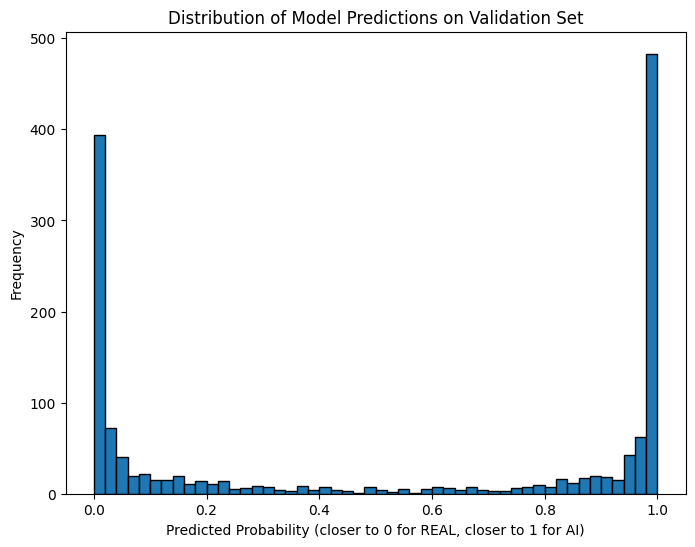


Prediction statistics for REAL images:
  Mean prediction: 0.1260
  Median prediction: 0.0161
  Min prediction: 0.0000
  Max prediction: 0.9838

Prediction statistics for AI images:
  Mean prediction: 0.9182
  Median prediction: 0.9948
  Min prediction: 0.0001
  Max prediction: 1.0000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions on the validation set
predictions = model.predict(X_val)

# Plot the distribution of predictions
plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=50, edgecolor='black')
plt.title('Distribution of Model Predictions on Validation Set')
plt.xlabel('Predicted Probability (closer to 0 for REAL, closer to 1 for AI)')
plt.ylabel('Frequency')
plt.show()

# Analyze the distribution
real_predictions = predictions[y_val == 0]
ai_predictions = predictions[y_val == 1]

print("\nPrediction statistics for REAL images:")
print(f"  Mean prediction: {np.mean(real_predictions):.4f}")
print(f"  Median prediction: {np.median(real_predictions):.4f}")
print(f"  Min prediction: {np.min(real_predictions):.4f}")
print(f"  Max prediction: {np.max(real_predictions):.4f}")


print("\nPrediction statistics for AI images:")
print(f"  Mean prediction: {np.mean(ai_predictions):.4f}")
print(f"  Median prediction: {np.median(ai_predictions):.4f}")
print(f"  Min prediction: {np.min(ai_predictions):.4f}")
print(f"  Max prediction: {np.max(ai_predictions):.4f}")

### Forensic Feature Analysis

Let's visualize the distributions of the extracted forensic features for "REAL" and "AI" images to see how they differ.

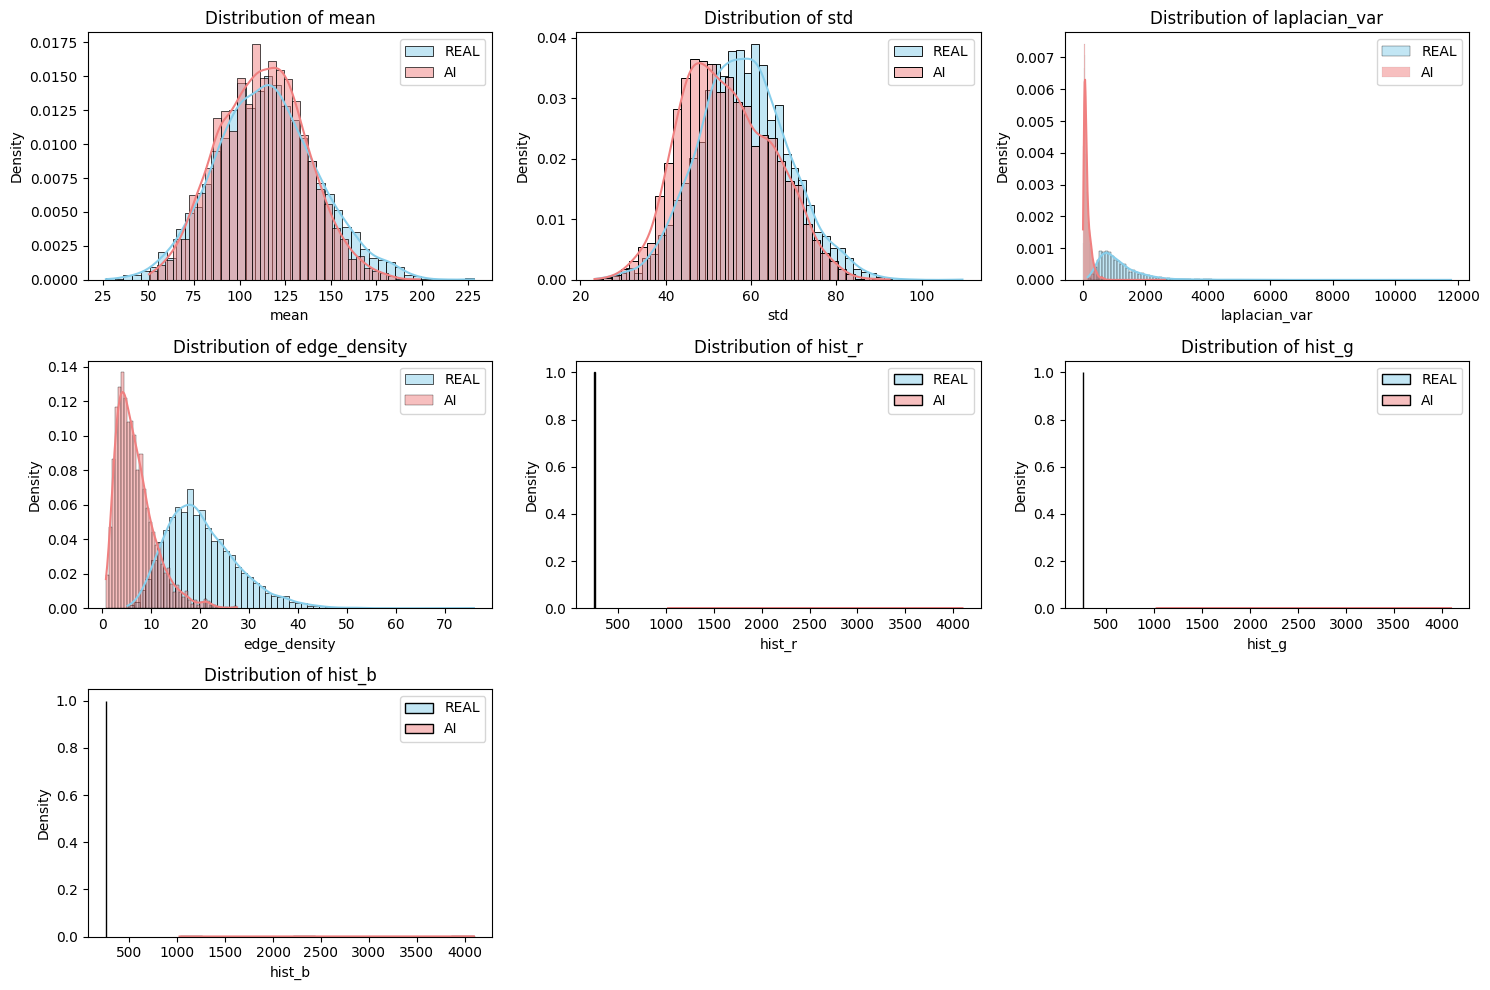

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' DataFrame with forensic features and 'label' column is available
# If not, load it again:
# df = pd.read_csv("forensic_features.csv")

# Separate features by label
df_real = df[df['label'] == 0]
df_ai = df[df['label'] == 1]

# List of forensic features
forensic_features = ['mean', 'std', 'laplacian_var', 'edge_density', 'hist_r', 'hist_g', 'hist_b']

# Plot distributions for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(forensic_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_real[feature], color='skyblue', label='REAL', kde=True, stat='density', common_norm=False)
    sns.histplot(df_ai[feature], color='lightcoral', label='AI', kde=True, stat='density', common_norm=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()

plt.show()

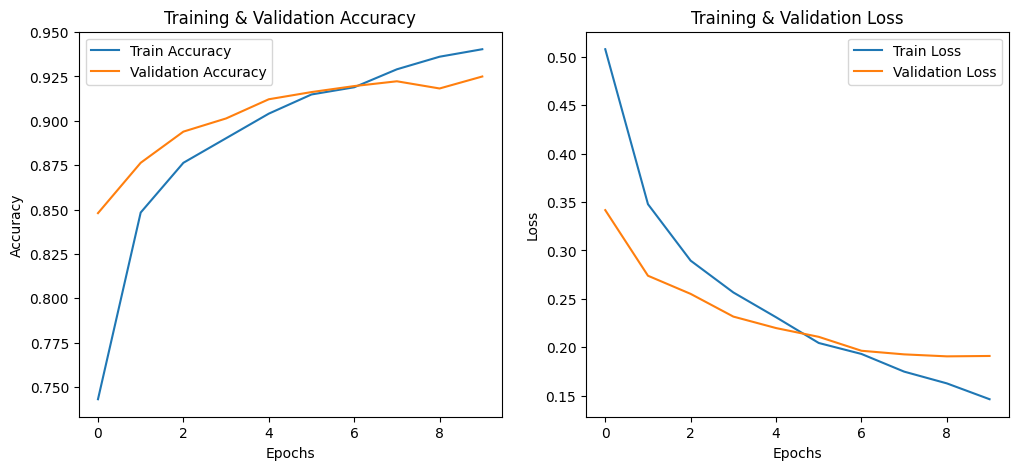

Final Validation Accuracy: 0.9250
Final Validation Loss: 0.1909


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' object from model training is available
# If not, you might need to retrain or load the history if saved

# Plot training history (Accuracy and Loss)
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Print final accuracy
loss, acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Accuracy: {acc:.4f}")
print(f"Final Validation Loss: {loss:.4f}")

# Task
Summarize the project, including the goal, the approach (hybrid model with CNN and forensic features), key steps (data preparation, feature extraction, model training), and the final performance. Also, provide code to save the trained hybrid model.

## Summarize the project

### Subtask:
Create a markdown summary of the project, including the goal, the approach (hybrid model with CNN and forensic features), key steps (data preparation, feature extraction, model training), and the final performance.


```markdown
## Project Summary: Real vs. AI Image Classification

**Goal:** The primary objective of this project was to build a model capable of distinguishing between real and AI-generated images.

**Approach:** A hybrid modeling approach was employed, combining two distinct types of features:
1.  **CNN Features:** Leveraging a pre-trained MobileNetV2 model (without the top classification layer) as a feature extractor to capture high-level, abstract visual patterns.
2.  **Forensic Features:** Extracting handcrafted features based on image processing techniques, such as mean pixel value, standard deviation, Laplacian variance (sharpness), edge density, and color histograms (R, G, B), which can reveal artifacts specific to image generation processes.

These two sets of features were concatenated to create a comprehensive representation for each image, which was then fed into a dense neural network classifier.

**Key Steps:**

1.  **Data Preparation:**
    *   Downloaded the "Real vs. AI Images" dataset from Kaggle.
    *   Unzipped the dataset and reorganized the directory structure to separate "REAL" and "AI" images into distinct folders.
    *   Sampled 3700 images from each class to create a balanced final dataset.

2.  **Feature Extraction:**
    *   Iterated through the prepared dataset.
    *   For each image:
        *   Loaded and preprocessed the image for input into the MobileNetV2 model to extract CNN features.
        *   Applied image processing techniques (using OpenCV) to extract the seven handcrafted forensic features.

3.  **Feature Combination and Scaling:**
    *   Concatenated the extracted CNN features and forensic features into a single feature vector for each image.
    *   Scaled the forensic features using `StandardScaler` to ensure they were on a similar scale as the CNN features, preventing features with larger magnitudes from dominating the model training.

4.  **Data Splitting:**
    *   Split the combined feature dataset into training (80%) and validation (20%) sets using `train_test_split`, ensuring stratification to maintain the class distribution in both sets.

5.  **Model Building and Training:**
    *   Constructed a simple dense neural network with dropout layers on top of the combined features.
    *   Compiled the model using the Adam optimizer and binary cross-entropy loss, with accuracy as the evaluation metric.
    *   Trained the hybrid model on the training data for 10 epochs, validating its performance on the validation set after each epoch.

**Final Performance:**

After training for 10 epochs, the hybrid model achieved the following performance metrics on the validation set:

*   **Final Validation Accuracy:** 0.9250
*   **Final Validation Loss:** 0.1909

This indicates that the hybrid approach, combining visual features from a pre-trained CNN and handcrafted forensic features, was effective in classifying real and AI-generated images with high accuracy on this dataset.

### Save the Trained Hybrid Model

Let's save the trained hybrid model so it can be reused later without retraining. We'll save it in the TensorFlow SavedModel format, which is the recommended way to save TensorFlow models.

In [ ]:
# Save the trained hybrid model
model_save_path = "hybrid_real_vs_ai_model.keras" # Added .keras extension
model.save(model_save_path)

print(f"✅ Hybrid model saved successfully to {model_save_path}")

✅ Hybrid model saved successfully to hybrid_real_vs_ai_model.keras
